# Extracting, analyzing and visualizing spatial entities from Tripadvisor text data

## Libraries and Settings

In [1]:
# Install library spacy (use Terminal, install in activated conda environment)
# pip install spacy
# python -m spacy download en_core_web_sm
# python -m spacy download de_core_news_sm

# Libraries
import spacy
import os
import requests
import folium
from folium import Popup
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print(os.getcwd())

u:\Lektionen\WPM\spatial_data_analysis\08_Python_Tripadvisor


## Import data

In [12]:
# Data from Tripadvisor derived via web scraping (https://www.tripadvisor.com)
df = pd.read_csv('tripadvisor.csv')

# Get the shape of the dataframe
print(df.shape)

df.head(10)

(282, 7)


,web-scraper-order,web-scraper-start-url,title_raw,price_raw,ranking_raw,duration_raw,text_raw
0,1713267369-1,https://www.tripadvisor.ch/Attraction_Products...,31. Titlis-Tagesausflug mit privatem Reiseleit...,CHF 496,5.0 von fünf Punkten1,6 - 8 Stunden,31. Titlis-Tagesausflug mit privatem Reiseleit...
1,1713267369-2,https://www.tripadvisor.ch/Attraction_Products...,32. Alpine Majestät: Exklusive Privattour von ...,CHF 699,NaN,Mehr als 6 Stunden,32. Alpine Majestät: Exklusive Privattour von ...
2,1713267369-3,https://www.tripadvisor.ch/Attraction_Products...,33. Privattour zu den atemberaubendsten Inside...,CHF 1’999,5.0 von fünf Punkten47,Mehr als 6 Stunden,33. Privattour zu den atemberaubendsten Inside...
3,1713267369-4,https://www.tripadvisor.ch/Attraction_Products...,34. Vierwaldstättersee Pick and Mix Tour - Bur...,CHF 689,5.0 von fünf Punkten34,8 - 9 Stunden,34. Vierwaldstättersee Pick and Mix Tour - Bur...
4,1713267369-5,https://www.tripadvisor.ch/Attraction_Products...,35. Atemberaubende private Wanderung mit einem...,CHF 899,5.0 von fünf Punkten26,8 - 9 Stunden,35. Atemberaubende private Wanderung mit einem...
5,1713267369-6,https://www.tripadvisor.ch/Attraction_Products...,36. Best of Bernese Oberland Tour ab Interlaken,CHF 721,5.0 von fünf Punkten12,Mehr als 6 Stunden,36. Best of Bernese Oberland Tour ab Interlake...
6,1713267369-7,https://www.tripadvisor.ch/Attraction_Products...,37. Die Naturwunder der Schweiz: Privattour ab...,CHF 959,5.0 von fünf Punkten11,Mehr als 6 Stunden,37. Die Naturwunder der Schweiz: Privattour ab...
7,1713267369-8,https://www.tripadvisor.ch/Attraction_Products...,38. Ganztägige Wanderung durch die Schweizer A...,CHF 148,5.0 von fünf Punkten9,8 - 11 Stunden,38. Ganztägige Wanderung durch die Schweizer A...
8,1713267369-9,https://www.tripadvisor.ch/Attraction_Products...,39. Best of Berner Oberland & Schweizer Landsc...,CHF 680,5.0 von fünf Punkten8,Mehr als 6 Stunden,39. Best of Berner Oberland & Schweizer Landsc...
9,1713267369-10,https://www.tripadvisor.ch/Attraction_Products...,40. Bruchlandung auf Ihrer privaten Tagestour ...,CHF 965,5.0 von fünf Punkten8,8 - 9 Stunden,40. Bruchlandung auf Ihrer privaten Tagestour ...


## Extract locations

### Show locations in titles

In [3]:
print(df['title_raw'])

print('\n', df.loc[df['web-scraper-order'] == '1713267369-281']['title_raw'].values[0])

0      31. Titlis-Tagesausflug mit privatem Reiseleit...
1      32. Alpine Majestät: Exklusive Privattour von ...
2      33. Privattour zu den atemberaubendsten Inside...
3      34. Vierwaldstättersee Pick and Mix Tour - Bur...
4      35. Atemberaubende private Wanderung mit einem...
                             ...                        
277    248. Lugano und Morcote, private Führung ab Ma...
278      249. VIP-Erlebnis zum Comer See und nach Lugano
279    250. Jungfraujoch Top of Europe und Region Pri...
280    251.  Ganztägiger Privatausflug von Zürich nac...
281    252. Ab Zürich: Private Schneewanderung, Berg-...
Name: title_raw, Length: 282, dtype: object

 251.  Ganztägiger Privatausflug von Zürich nach Interlaken und Grindelwald


### Extract locations by using NLP methods provided by the library 'spacy'

In [4]:
# Load the German language model
nlp = spacy.load("de_core_news_sm")

# Example texts with their identifiers
texts = df[['web-scraper-order', 'title_raw']]

# Function to extract locations, their labels, and the ID from original data
def extract_locations(texts):
    locations = []
    for idx, row in texts.iterrows():
        doc = nlp(row['title_raw'])
        for ent in doc.ents:
            if ent.label_ == "LOC" or ent.label_ == "GPE":
                locations.append((row['web-scraper-order'], ent.text, ent.label_))
    return locations

# Extract locations
locations_with_labels_ids = extract_locations(texts)

# Create a DataFrame with location names, their labels, and the IDs
df_locations = pd.DataFrame(locations_with_labels_ids, columns=['web-scraper-order', 'location', 'entity_type'])

# Remove duplicate locations
df_locations_unique = df_locations.drop_duplicates().reset_index(drop=True)

# Filter out location names longer than 25 characters
df_locations_filtered = df_locations_unique[df_locations_unique['location'].apply(len) <= 25]

# Display the DataFrame
print(df_locations_filtered)

    web-scraper-order          location entity_type
0        1713267369-1            Luzern         LOC
1        1713267369-3       der Schweiz         LOC
3        1713267369-4  Rigi Seebodenalp         LOC
4        1713267369-4            Luzern         LOC
5        1713267369-7       der Schweiz         LOC
..                ...               ...         ...
470    1713267369-280            Zürich         LOC
471    1713267369-281            Zürich         LOC
472    1713267369-281        Interlaken         LOC
473    1713267369-281       Grindelwald         LOC
474    1713267369-282            Zürich         LOC

[470 rows x 3 columns]


## Geocode locations

In [5]:
# Define the base URL for the GeoAdmin API
base_url = "https://api3.geo.admin.ch/rest/services/api/SearchServer?"

# Initialize a list to store IDs, coordinates, or NA along with location names
coordinates_list = []

# Loop through each address and ID in the DataFrame
for idx, row in df_locations_filtered.iterrows():
    # Set up search parameters for each location
    parameters = {
        "searchText": row['location'],
        "origins": "address",
        "type": "locations"
    }

    # Send the request to the GeoAdmin API
    response = requests.get(base_url, params=parameters)

    # Check the response status and process the data
    if response.status_code == 200:
        data = response.json()
        if data['results']:
            first_result = data['results'][0]['attrs']
            lat = first_result.get('lat', None)
            lon = first_result.get('lon', None)
            coordinates_list.append([row['web-scraper-order'], 
                                     row['location'], lat, lon])
        else:
            coordinates_list.append([row['web-scraper-order'], 
                                     row['location'], None, None])
    else:
        coordinates_list.append([row['web-scraper-order'], 
                                 row['location'], None, None])

# Convert the list to a DataFrame with specified column names
df_geocoded = pd.DataFrame(coordinates_list, columns=['web-scraper-order', 
                                                      'location', 
                                                      'latitude', 
                                                      'longitude'])

# Display the DataFrame
print(df_geocoded)


    web-scraper-order          location   latitude  longitude
0        1713267369-1            Luzern  47.052547   8.282178
1        1713267369-3       der Schweiz  47.425415   8.400759
2        1713267369-4  Rigi Seebodenalp  47.062836   8.467160
3        1713267369-4            Luzern  47.052547   8.282178
4        1713267369-7       der Schweiz  47.425415   8.400759
..                ...               ...        ...        ...
465    1713267369-280            Zürich  47.141186   7.629510
466    1713267369-281            Zürich  47.141186   7.629510
467    1713267369-281        Interlaken  46.689419   7.889520
468    1713267369-281       Grindelwald  47.032753   8.096479
469    1713267369-282            Zürich  47.141186   7.629510

[470 rows x 4 columns]


## Merge the original DataFrame with the geocoded DataFrame

In [6]:
# Merge the original DataFrame with the geocoded DataFrame
merged_df = pd.merge(df[['web-scraper-order', 
                         'title_raw', 
                         'price_raw', 
                         'ranking_raw', 
                         'duration_raw']], df_geocoded, 
                         on='web-scraper-order', 
                         how='left')
merged_df

,web-scraper-order,title_raw,price_raw,ranking_raw,duration_raw,location,latitude,longitude
0,1713267369-1,31. Titlis-Tagesausflug mit privatem Reiseleit...,CHF 496,5.0 von fünf Punkten1,6 - 8 Stunden,Luzern,47.052547,8.282178
1,1713267369-2,32. Alpine Majestät: Exklusive Privattour von ...,CHF 699,NaN,Mehr als 6 Stunden,NaN,NaN,NaN
2,1713267369-3,33. Privattour zu den atemberaubendsten Inside...,CHF 1’999,5.0 von fünf Punkten47,Mehr als 6 Stunden,der Schweiz,47.425415,8.400759
3,1713267369-4,34. Vierwaldstättersee Pick and Mix Tour - Bur...,CHF 689,5.0 von fünf Punkten34,8 - 9 Stunden,Rigi Seebodenalp,47.062836,8.467160
4,1713267369-4,34. Vierwaldstättersee Pick and Mix Tour - Bur...,CHF 689,5.0 von fünf Punkten34,8 - 9 Stunden,Luzern,47.052547,8.282178
...,...,...,...,...,...,...,...,...
509,1713267369-280,250. Jungfraujoch Top of Europe und Region Pri...,CHF 1’046,NaN,Mehr als 6 Stunden,Zürich,47.141186,7.629510
510,1713267369-281,251. Ganztägiger Privatausflug von Zürich nac...,CHF 1’688,NaN,Mehr als 6 Stunden,Zürich,47.141186,7.629510
511,1713267369-281,251. Ganztägiger Privatausflug von Zürich nac...,CHF 1’688,NaN,Mehr als 6 Stunden,Interlaken,46.689419,7.889520
512,1713267369-281,251. Ganztägiger Privatausflug von Zürich nac...,CHF 1’688,NaN,Mehr als 6 Stunden,Grindelwald,47.032753,8.096479


## Analyse price

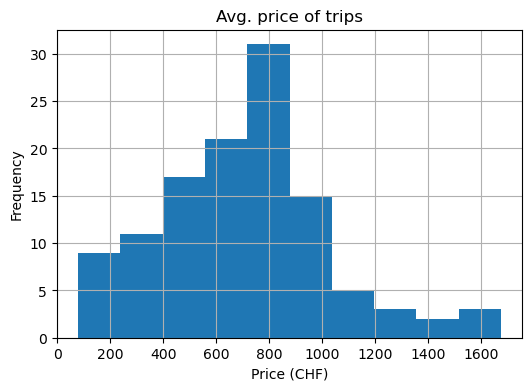

In [7]:
# Merge the original DataFrame with the geocoded DataFrame
merged_df = pd.merge(df[['web-scraper-order', 
                         'title_raw', 
                         'price_raw', 
                         'ranking_raw', 
                         'duration_raw']], df_geocoded, 
                         on='web-scraper-order', 
                         how='left')

# Extract numbers from the string
merged_df['price'] = merged_df['price_raw'].str.strip()
merged_df['price'] = merged_df['price'].str.extract(r'(\d+’?\d*)')
merged_df['price'] = merged_df['price'].str.replace("’", "").astype(int)
merged_df

# Pivot table to get the average price for each location
pivot_table = merged_df.pivot_table(index='location', 
                                    values='price', 
                                    aggfunc='mean').reset_index()

pivot_table.sort_values(by='price', ascending=False)

# Histogram with average price of trips
plt.figure(figsize=(6, 4))
plt.hist(pivot_table['price'])
plt.title('Avg. price of trips')
plt.xlabel('Price (CHF)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

## Analyse duration


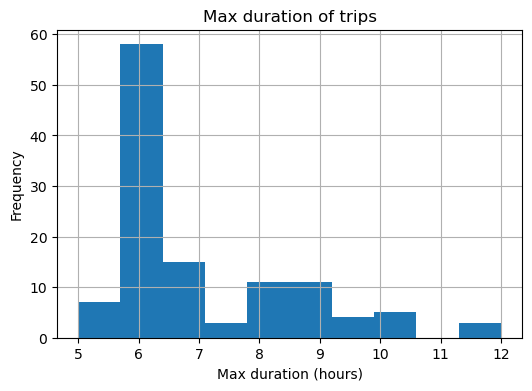

In [13]:
# Extract numbers from the string
merged_df['max_duration'] = merged_df['duration_raw'].str.strip()
merged_df['max_duration'] = merged_df['max_duration'].str.extractall(r'(\d+)').astype(int).groupby(level=0).max()

# Pivot table to get the average duration for each trip
pivot_table = merged_df.pivot_table(index='location', 
                                    values='max_duration', 
                                    aggfunc='mean').reset_index()

sorted_pivot = pivot_table.sort_values(by='max_duration', ascending=False)

# Histogram with average max. duration of trips
plt.figure(figsize=(6, 4))
plt.hist(pivot_table['max_duration'])
plt.title('Max duration of trips')
plt.xlabel('Max duration (hours)')
plt.ylabel('Frequency')
plt.grid()
plt.show()


## Analyse ranking

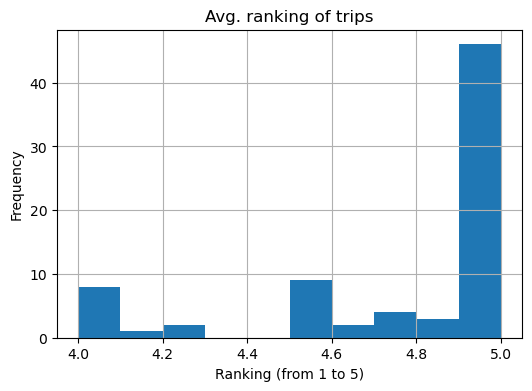

In [9]:
# Extract numbers from the string
merged_df['ranking'] = merged_df['ranking_raw'].str.strip()
merged_df['ranking'] = merged_df['ranking'].str[:3].astype(float)
merged_df

# Pivot table to get the average ranking for each trip
pivot_table = merged_df.pivot_table(index='location', 
                                    values='ranking', 
                                    aggfunc='mean').reset_index()

pivot_table.sort_values(by='ranking', ascending=False)

# Histogram with avg. ranking of trips
plt.figure(figsize=(6, 4))
plt.hist(pivot_table['ranking'])
plt.title('Avg. ranking of trips')
plt.xlabel('Ranking (from 1 to 5)')
plt.ylabel('Frequency')
plt.grid()
plt.show()


## Plot on map

In [10]:
# Initialisierung der Map
m = folium.Map(location=[47.44, 8.65], zoom_start=8)

# Add lat/lon of addresses
df_sub = merged_df.dropna().drop_duplicates().reset_index(drop=True)
for i in range(0, len(df_sub)):
    popup_text = (
        f"Location: {df_sub.iloc[i]['location']}, "
        f"Ranking: {df_sub.iloc[i]['ranking']}, "
        f"Price: {df_sub.iloc[i]['price']}, "
        f"Duration: {df_sub.iloc[i]['max_duration']}"
    )
    popup = Popup(popup_text, max_width=500)  # Adjust the max_width as needed
    folium.Marker(location=(df_sub.iloc[i]['latitude'], df_sub.iloc[i]['longitude']), popup=popup).add_to(m)
    
# Layer control
folium.LayerControl().add_to(m)

# Plot map
m

### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [11]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
NT
Windows | 10
Datetime: 2024-04-16 18:41:27
Python Version: 3.10.11
-----------------------------------
